# Introduction

The `hep_tables` package is for prototyping a hierarchical access language in python. It has elements of `numpy`'s slicing syntax and elements of LINQ from C# in it. And whatever else seems to work. Be warned that lots of stuff is hardwired - especially the surrounding code, the backend, etc.

This requires that you have a `servicex` instance running as a datasource on local ports 5000 and 9000.

In [1]:
import sys
sys.path = ['..'] + sys.path
from hep_tables import xaod_table,make_local
from func_adl import EventDataset
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Just some code if you wanted to turn on a little info about what was going on.
#import logging
#logging.basicConfig(level=logging.NOTSET)
#logging.getLogger("urllib3").setLevel(logging.WARNING)
#logging.getLogger("matplotlib").setLevel(logging.WARNING)

Everything has to start from a dataset.

In [2]:
dataset = EventDataset('localds://mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00')

And we need to frame this as a hierarchical `DataFrame`. This implies some knowledge of how to translate it into columns, so here we need indicate that this is a dataset with ATLAS `xAOD` files in it.

In [3]:
df = xaod_table(dataset)

# Simple `numpy` syntax

First, lets just get all the $p_T$'s of jets from a data sample. Note that in ATLAS units are in `MeV`, but `GeV` just makes more sense. So divide the jet pt's by 1000.

In [4]:
%%time
pts = df.Electrons("Electrons").pt/1000.0

Wall time: 0 ns


We just have the DAG for generating the pt's of all jets. Next we need to actually run the thing

In [5]:
%%time
np_pts = make_local(pts)

Wall time: 3min 34s


In [6]:
print (type(np_pts))
print (len(np_pts))
np_pts

<class 'awkward.array.jagged.JaggedArray'>
1843800


<JaggedArray [[5.79458154296875] [36.92266796875 4.5147587890625 4.67144482421875 3.811003662109375] [] ... [44.0886484375 34.20717578125] [38.87487109375] [38.51691015625 35.75244140625 4.037018310546875]] at 0x02a074e061c8>

i:\gwatts\code\irishep\hep_tables\.venv\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
i:\gwatts\code\irishep\hep_tables\.venv\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


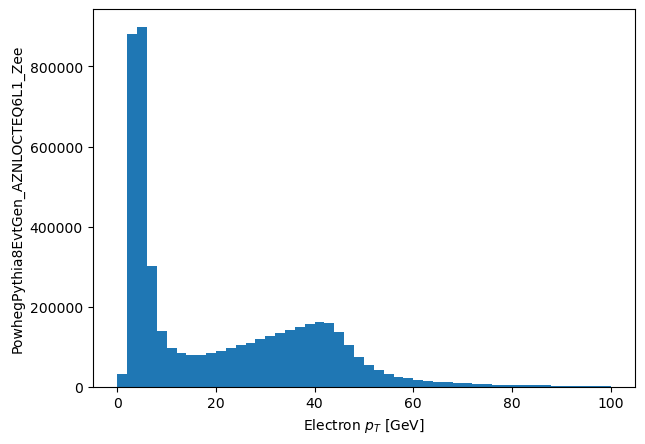

In [7]:
plt.hist(np_pts.flatten(), range=(0, 100), bins=50)
plt.xlabel('Electron $p_T$ [GeV]')
_ = plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')

## Filtering

What if we only want to look at the electrons with a pT above 50 GeV? Then we use the slice operations that we've become use to.

In [8]:
%%time
pts_good = df.Electrons("Electrons").pt[df.Electrons("Electrons").pt > 50000.0]/1000.0
np_pts_good = make_local(pts_good)

Wall time: 1min 31s


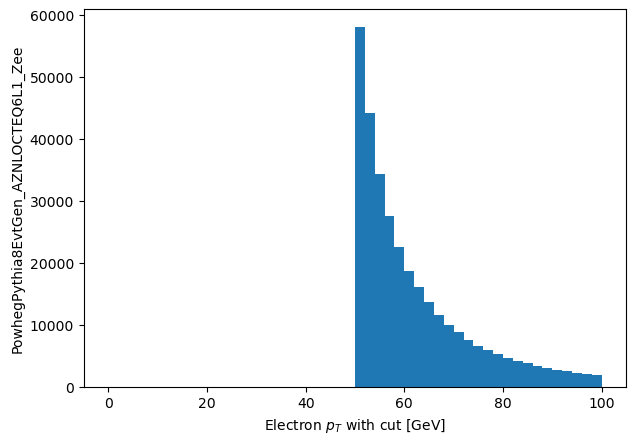

In [9]:
plt.hist(np_pts_good.flatten(), range=(0, 100), bins=50)
plt.xlabel('Electron $p_T$ with cut [GeV]')
_ = plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')

We can do this a little bit more in short hand:

In [10]:
%%time
eles = df.Electrons("Electrons")
pts_good_short = eles.pt[eles.pt > 50000.0]/1000.0
np_pts_good_short = make_local(pts_good)

Wall time: 1min 26s


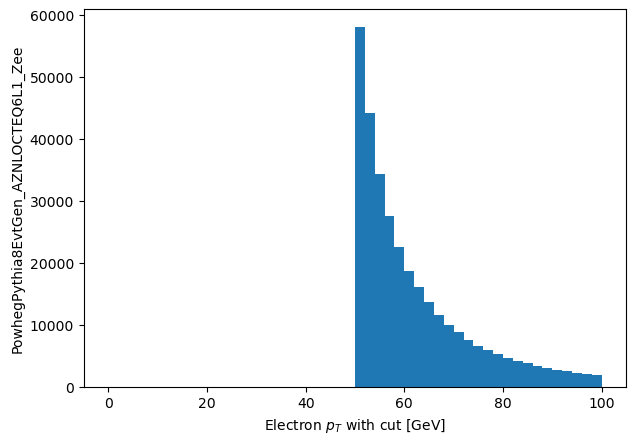

In [11]:
plt.hist(np_pts_good_short.flatten(), range=(0, 100), bins=50)
plt.xlabel('Electron $p_T$ with cut [GeV]')
_ = plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')

In the end, while this is interesting, probably, what we want to do, is look at all aspects of electrons after a $p_T$ cut and some sort of $\eta$ cut. In that case, we need to cut at the object level, not after calculating pt:

In [12]:
%%time
good_eles = eles[(eles.pt > 20000.0) & (abs(eles.eta) < 1.5)]
pts_good_whole = good_eles.pt/1000.0
np_pts_good_whole = make_local(pts_good_whole)

Wall time: 1min 46s


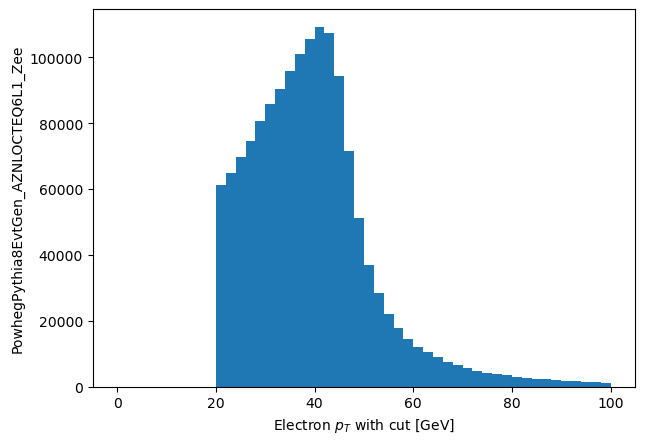

In [13]:
plt.hist(np_pts_good_whole.flatten(), range=(0, 100), bins=50)
plt.xlabel('Electron $p_T$ with cut [GeV]')
_ = plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')

So now we can look at the $\eta$ distributions before and after that cut if we like. Note we move the lists right inside the `make_local` call as we aren't going to really need those definitions elsewhere.

In [14]:
%%time
np_eta_all = make_local(eles.eta)
np_eta_good = make_local(good_eles.eta)

Wall time: 3min 44s


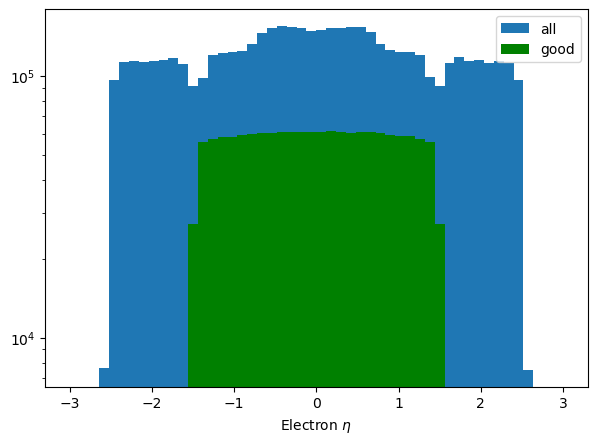

In [15]:
plt.hist(np_eta_all.flatten(), label='all', bins=50, range=(-3.0,3.0))
plt.hist(np_eta_good.flatten(), label='good', bins=50, range=(-3.0,3.0), color='g')
plt.yscale('log')
plt.xlabel('Electron $\eta$')
plt.legend();

## Cutting numbers of objects

So far the selection and filtering has all been on a single object - like a single electron having $p_T > 50$ GeV. What if you want to require at least two electrons that satisfy that requirement? To count the number of objects that satisfy a requirement, after the cuts, add the `Count()` method. `Count` will always count the number of objects it is looking at! It can be used both to get back counts and also to filter:

In [16]:
%%time
electron_counts = make_local(eles.Count())
good_electron_counts = make_local(good_eles.Count())

Wall time: 3min


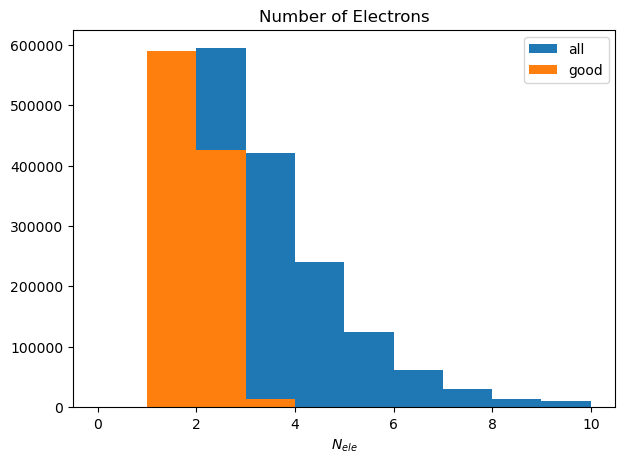

In [17]:
plt.hist(electron_counts[electron_counts>0], label='all', range=(0,10))
plt.hist(good_electron_counts[good_electron_counts>0], label='good', range=(0,10))
plt.xlabel('$N_{ele}$')
plt.title('Number of Electrons')
_ = plt.legend()

And we can also filter on number of electrons, creating a collection of events that have only two electrons:

In [18]:
%%time
good_events = df[eles.Count() == 2]
ele_per_event_count = make_local(good_events.Electrons("Electrons").Count())

Wall time: 1min 19s


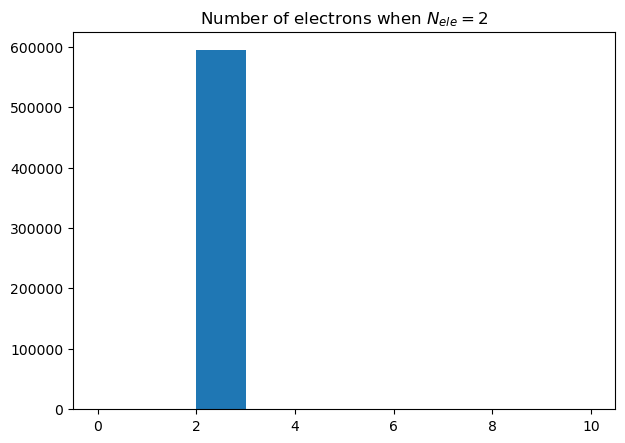

In [19]:
plt.hist(ele_per_event_count, range=(0,10))
_ = plt.title ('Number of electrons when $N_{ele} = 2$')